In [1]:
import glob
import warnings
warnings.filterwarnings('ignore')

from osgeo import gdal
from shapely import wkt
from typing import *
%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj
%matplotlib inline

import rasterio
from torch.utils.tensorboard import SummaryWriter
import skimage
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.ops import cascaded_union
import solaris as sol

from tqdm import tqdm, tqdm_notebook
import tifffile as sktif

import geopandas as gpd
import numpy as np
import cv2
from functools import partial

from fastai.imports import *
from fastai.vision import *
from fastai.metrics import dice
from fastai.callbacks import *
import ujson as json
from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    """Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"
from importlib import reload

env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj


W1120 21:43:41.198418 140211791886144 deprecation_wrapper.py:119] From /home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/solaris/nets/metrics.py:103: The name tf.keras.metrics.cosine_proximity is deprecated. Please use tf.keras.losses.cosine_similarity instead.

W1120 21:43:41.267814 140211791886144 deprecation_wrapper.py:119] From /home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/solaris/nets/_keras_losses.py:104: The name tf.keras.losses.cosine is deprecated. Please use tf.keras.losses.cosine_similarity instead.



In [2]:
data_dir = Path("/media/wwymak/Storage/xView2")
mask_dir = data_dir /"mask_full_size"

train_images_crops = data_dir/"train_crops"
# train_mask_crops = data_dir/"mask_crops"
train_mask_crops = data_dir/"mask_crops_single_channel"
test_images_crops = data_dir / "test_crops"
test_mask_crops = data_dir / "test_mask_crops_single_channel"

In [3]:
unique_img_ids = list(set([x.name.replace('mask_', '').split('.')[0] for x in train_mask_crops.ls() ]))
np.random.seed(42)
np.random.shuffle(unique_img_ids)
train_ids = unique_img_ids[:int(0.8 * len(unique_img_ids))]
valid_ids = unique_img_ids[int(0.8 * len(unique_img_ids)):]

def is_valid_func(fname):
    
    img_id = Path(fname).name.replace('rgb_', '').split('.')[0]

    return img_id in valid_ids

def get_mask_fn(fname):
    return train_mask_crops / fname.name.replace("rgb", "mask")

In [10]:
size=256
bs=16
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

src = (SegItemListCustom.from_folder(train_images_crops)
      .split_by_valid_func(is_valid_func)
       .label_from_func(get_mask_fn, classes=['void', 'building']))

data = (src.transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=True)
        .add_test_folder(test_images_crops, tfm_y=False)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

data

ImageDataBunch;

Train: LabelList (12538 items)
x: SegItemListCustom
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegLabelListCustom
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /media/wwymak/Storage/xView2/train_crops;

Valid: LabelList (3227 items)
x: SegItemListCustom
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegLabelListCustom
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /media/wwymak/Storage/xView2/train_crops;

Test: LabelList (8397 items)
x: SegItemListCustom
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: /media/wwymak/Storage/xView2/train_crops

In [13]:
models_path = data_dir / "models"
metrics =  [foreground_acc, dice]
# learn.model_dir = models_path
learn = unet_learner(data, models.resnet34, metrics=metrics, model_dir = models_path)
learn.to_fp16();
learn.load('17Nov-xview_buildings_default_unet')

Learner(data=ImageDataBunch;

Train: LabelList (12538 items)
x: SegItemListCustom
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegLabelListCustom
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /media/wwymak/Storage/xView2/train_crops;

Valid: LabelList (3227 items)
x: SegItemListCustom
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegLabelListCustom
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /media/wwymak/Storage/xView2/train_crops;

Test: LabelList (8397 items)
x: SegItemListCustom
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: /media/wwymak/Storage/xView2/train_crops, model=DynamicUnet(
  (layers): Mod

In [14]:
data.test_dl.dataset.items

array([PosixPath('/media/wwymak/Storage/xView2/test_crops/rgb_test_pre_00072_5.png'),
       PosixPath('/media/wwymak/Storage/xView2/test_crops/rgb_test_pre_00832_2.png'),
       PosixPath('/media/wwymak/Storage/xView2/test_crops/rgb_test_pre_00562_6.png'),
       PosixPath('/media/wwymak/Storage/xView2/test_crops/rgb_test_pre_00748_6.png'), ...,
       PosixPath('/media/wwymak/Storage/xView2/test_crops/rgb_test_pre_00840_1.png'),
       PosixPath('/media/wwymak/Storage/xView2/test_crops/rgb_test_pre_00500_4.png'),
       PosixPath('/media/wwymak/Storage/xView2/test_crops/rgb_test_pre_00840_4.png'),
       PosixPath('/media/wwymak/Storage/xView2/test_crops/rgb_test_pre_00547_4.png')], dtype=object)

In [17]:
test_predictions = learn.get_preds(ds_type=DatasetType.Test)

In [21]:
learn.get_preds??

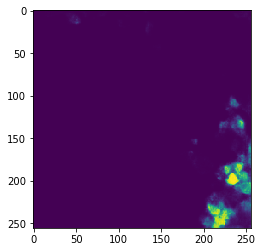

In [40]:
plt.imshow(test_predictions[0][1][1].numpy())

In [39]:
results = torch.max(test_predictions[0], dim=1).indices

results.shape

torch.Size([8397, 256, 256])

In [43]:
results = results.numpy().astype(np.uint8)

In [47]:
for idx, fname in tqdm(zip(np.arange(len(results)), [test_mask_crops/x.name for x in data.test_dl.dataset.items])):
    img = PIL.Image.fromarray(results[idx])
    img.save(fname, mode='L')               

8397it [00:04, 2006.49it/s]


In [4]:
test_mask_crops.ls()[5]

PosixPath('/media/wwymak/Storage/xView2/test_mask_crops_single_channel/rgb_test_pre_00408_5.png')

In [29]:
img = cv2.imread(str(test_mask_crops.ls()[5]))
w, h = img.shape[:2]
print(w, h), 

out = cv2.resize(img, (2*w, 2*h))
out=cv2.cvtColor(out, cv2.COLOR_BGR2GRAY)
out.shape, out.max()

256 256


((512, 512), 1)

In [22]:
cv2.imwrite('test.png',out )
a = cv2.imread('test.png',  cv2.IMREAD_GRAYSCALE)
a.min(), a.max(), a.shape

(0, 1, (512, 512))

In [36]:
def resize_and_save(img_path):
    img = cv2.imread(str(img_path))
    w, h = img.shape[:2]

    out = cv2.resize(img, (2*w, 2*h))
    out=cv2.cvtColor(out, cv2.COLOR_BGR2GRAY)
    cv2.imwrite(str(img_path), out)

In [37]:

%%time 
_ = Parallel(n_jobs=14)(delayed(resize_and_save)(img_filepath) for img_filepath in test_mask_crops.ls())

CPU times: user 960 ms, sys: 96.3 ms, total: 1.06 s
Wall time: 9.85 s


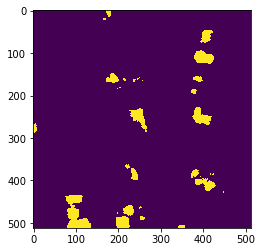

In [39]:
plt.imshow(cv2.imread(str(test_mask_crops.ls()[5]), cv2.IMREAD_GRAYSCALE))

In [52]:
test_mask_crops.ls()[5]

PosixPath('/media/wwymak/Storage/xView2/test_mask_crops_single_channel/rgb_test_pre_00408_5.png')

In [47]:
img_ids = list(set(['_'.join(x.name.split('_')[:-1]) for x in test_mask_crops.ls()]))
test_mask_crops.ls()[:5]

[PosixPath('/media/wwymak/Storage/xView2/test_mask_crops_single_channel/rgb_test_pre_00072_5.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_mask_crops_single_channel/rgb_test_pre_00832_2.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_mask_crops_single_channel/rgb_test_pre_00562_6.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_mask_crops_single_channel/rgb_test_pre_00748_6.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_mask_crops_single_channel/rgb_test_pre_00850_8.png')]

In [44]:
boxes = [
        (0, 0, 512, 512),
        (0, 256, 512, 768),
        (0, 512, 512, 1024),
        (256, 0, 768, 512),
        (256, 256, 768, 768),
        (256, 512, 768, 1024),
        (512, 0, 1024, 512),
        (512, 256, 1024, 768),
        (512, 512, 1024, 1024)
    ]



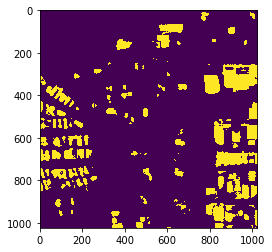

In [53]:
full_img = np.zeros((1024,1024))

for i in range(9):
    arr = PIL.Image.open(test_mask_crops/f"{'rgb_test_pre_00408'}_{i}.png")
    start_index_row, start_index_col = boxes[i][1], boxes[i][0]
    end_index_row, endindex_col = boxes[i][3], boxes[i][2]
    full_img[start_index_row:end_index_row, start_index_col: endindex_col] = arr
#     to_combine.append(full_img)


In [62]:
full_img.max()

1.0

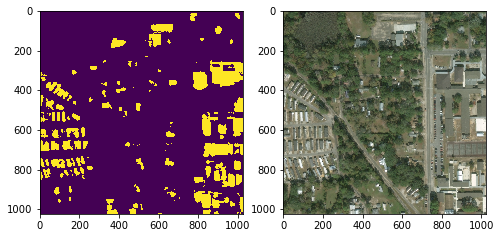

In [60]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
axs = ax.ravel()
axs[0].imshow(full_img.astype(np.uint8))
axs[1].imshow(PIL.Image.open(data_dir/"test"/"images"/"test_pre_00408.png"))

In [71]:
test_masks = data_dir/"test_masks"
test_masks.mkdir(exist_ok=True)

def combine_images(img_id):
    full_img = np.zeros((1024,1024))

    for i in range(9):
        arr = PIL.Image.open(test_mask_crops/f"{img_id}_{i}.png")
        start_index_row, start_index_col = boxes[i][1], boxes[i][0]
        end_index_row, endindex_col = boxes[i][3], boxes[i][2]
        full_img[start_index_row:end_index_row, start_index_col: endindex_col] = arr
        
    img = PIL.Image.fromarray(full_img.astype(np.uint8))
    img.save(test_masks/f"{img_id.replace('rgb_', '')}.png", mode="L")
    

In [72]:
%%time 
_ = Parallel(n_jobs=14)(delayed(combine_images)(img_id) for img_id in img_ids)

CPU times: user 867 ms, sys: 34.3 ms, total: 902 ms
Wall time: 2.57 s


In [73]:
test_masks.ls()[:2]

[PosixPath('/media/wwymak/Storage/xView2/test_masks/test_pre_00909.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_masks/test_pre_00371.png')]